In [9]:
import torch

import os

os.environ['TRANSFORMERS_CACHE'] = '../../pretrained_models/hugging_face'

from transformers import AutoModel, AutoTokenizer, T5ForConditionalGeneration, T5Tokenizer, BartForConditionalGeneration, BartTokenizer, GPTJForCausalLM, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
import re


In [10]:
device = 'cpu'
device

'cpu'

In [16]:

model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
model_path = f'sberbank-ai/rugpt3medium_based_on_gpt2_train/checkpoint-84000'

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_path)


In [26]:
def generate_text(prompt, device, tokenizer):
    model.to(device)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(
        input_ids,
        min_length=64,
        max_length=128,
        num_beams=2,
        no_repeat_ngram_size=2,
        top_k=10, 
        top_p=0.5, 
        early_stopping=True,
        do_sample=True,
        temperature=10.0

    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [29]:
prompt = 'блондинка отчаялась и спрыгнула с небоскреба'
generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)

блондинка отчаялась и спрыгнула с небоскреба, как будто сама судьба хотела бросить ей вызов в полт. она, облачнная в лгкий фартук из белого льна, стала взбираться на высокую башню, где, по е мнению, сосредоточены были все тайны мира.не подозревая о тех, кто следит за ней, она подошла к самой вершине. и, о чудо на самом верхнем плато, в окружении пушистого мха и ослепительных розовых лепестков, ей встретился рыцарь в сверкающих доспехах, которых никто из жителей города не видел. их глаза, словно два бездонных озера,


Я буду обучать модель на своих сгенерированных текстах. Мои тексты длиннее 1024 токонов (ограничение gpt2). Для того, чтобы при создании батча из набора текстов у меня все хорошо работало, я каждый текст буду разбивать на части. Нарисую графики длины текстов в токенах для оценки величины проблемы

In [4]:
# dataset_paths = [
#     '../dataset/generated/generated_curious_pushkin.txt',
#     '../dataset/generated/generated_pushkin.txt',
# ]
# all_texts = []
# for path in dataset_paths:
#     with open(path, 'r', encoding='utf-8') as f:
#         texts = f.read().replace('\n', '').lower()
#         texts = re.sub(r'[^а-яА-ЯёЁ,.# ]', '', texts)
#         texts = texts.split('#' * 10)

#         all_texts += [t.strip().lower() for t in texts if len(t) > 50]

# tokenized_texts = [tokenizer.encode(all_texts[i]) for i in range(len(all_texts))]

In [5]:
# tok_lens = [len(t) for t in tokenized_texts]
# plt.figure(figsize=(16, 8))
# plt.ylim((0, 5000))
# plt.scatter(np.arange(len(tok_lens)), tok_lens, s=1)

буду каждый текст делить на 10 перехлестывающихся отрезка по 1024 токена. В таком случае размер перехлеста с каждой из сторон будет ~300 токенов, что довольно не мало с точки зрения контекста

In [6]:
# функция для создания датасета

def load_dataset(file_paths, tokenizer, block_size=512, multip=20):
    tokenized_texts = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as f:
            texts = f.read().replace('\n', '').lower()
            texts = re.sub(r'[^а-яА-ЯёЁ,.# ]', '', texts)
            texts = texts.split('#' * 10)

            tokenized_texts.extend([tokenizer.encode(t.strip()) for t in texts if len(t) > 50])


    # режу тексты на нахлестывающиеся отрезки
    overlapped_texts = []
    for text in tokenized_texts:
        if len(text) > block_size:
            step = max(1, (len(text) - block_size) // (multip - 1))
            for i in range(0, min(len(text) - block_size + 1, block_size * (multip - 1) + 1), step):
                overlapped_texts.append(text[i: i + block_size])
        else:
            overlapped_texts.append(text)

    
    encodings = torch.tensor(overlapped_texts, dtype=torch.long)

    return encodings

In [7]:
dataset_paths = [
    '../dataset/generated/generated_curious_pushkin.txt',
    '../dataset/generated/generated_pushkin.txt',
]

block_size = 1024
multip = 8
train_dataset = load_dataset(dataset_paths, tokenizer, block_size=block_size)
len(train_dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (3252 > 1024). Running this sequence through the model will result in indexing errors


142860

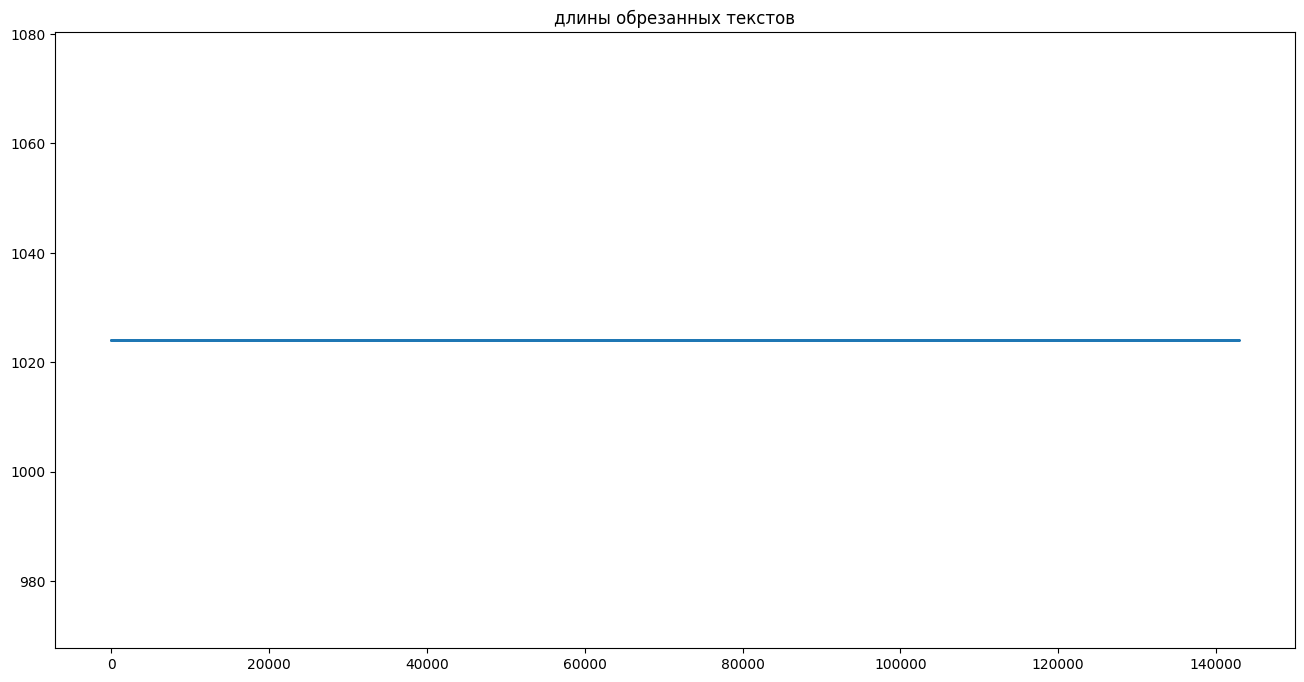

In [8]:
lens = [len(t) for t in train_dataset]
plt.figure(figsize=(16, 8))
plt.title('длины обрезанных текстов')
plt.scatter(np.arange(len(lens)), lens, s=0.1)



In [9]:
num_epochs = 4

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir=f'{model_name}_train',
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=1,
    save_steps=20_000,
    save_total_limit=2,
    fp16=True,
    logging_dir=f'{model_name}_train/logs', 
    logging_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)


d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

path = f'{model_name}_train/{model_name}_{num_epochs}_epochs'

trainer.save_model(path)
tokenizer.save_pretrained(path)


d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss
1000,1.599600
2000,1.388300
3000,1.306000
4000,1.249200
5000,1.212200
6000,1.178700
7000,1.150600
8000,1.137000
9000,1.107300
10000,1.089700


In [17]:
model_name = 'gpt2-medium'
model_path =  f'{model_name}_train/checkpoint-300000'

device = 'cpu'

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# tokenizer = Tokenizer.from_file('../dataset/generated/tokenizer_and_tokenized_dataset/tokenizer_2_vocab_1410_made_on_generated_data')
model = GPT2LMHeadModel.from_pretrained(model_path, pad_token_id=tokenizer.eos_token_id).to(device)
# 

In [18]:
def generate_text(prompt, device, tokenizer):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(
        input_ids,
        min_length=64,
        max_length=1024,
        num_beams=2,
        no_repeat_ngram_size=2,
        top_k=5, 
        top_p=0.5, 
        early_stopping=True,
        do_sample=True,
        temperature=0.2

    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [20]:
prompt = 'в туманной слободе, на берегу невидимой реки, где заблудились звезды'
generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)

в туманной слободе, на берегу невидимой реки, где заблудились звезды и луна, что приносит весть  живущая мужа. е дурные улохи осенял камни  являяся ладкозелецом артемий.с , йполиус,недаль,как Їасы,сметают,дождя,иктоватыфея.он крутие,лвянко,лд,откнувши.аръирок .скворкуи�мывав,вдраиь.и,всэтяк,а,с Ѝнтрыллѱоярсук.клынья, кроио�нссвят,ряд Єлр а вого.в Іеопии,, Ўнѳиям муяаьвысоу.нд еуа�иаеаыр,меи�у,мое.ла.я. Љи.о ы,о,ао. и�и.. о�ыт,иы.вмяедь,.рв,,ыкео�,у �саоотду�,я... �.лв.к д,м Јону,тврд.и�рмсоил,еьм.я.. �,р,яи... н,доем,тм�ьк,е.а Ѕрон,у�ее ', �вномѲлн.лсн�с. ьис,оЄиѹ �р�в.мр.тѿлк�,,н�ы.,к.а� Њрьт�рр..н�,� �ааууо�,�ы,,ср�днм,двн �с.н�ьи�ккс�и�и�е�,оЍл�нр �л,ь.т.дм�с�р�н�ым�Lens,� Oriи�р�ье..,,.,� �у.м�р.оЎр�а,,и�о�м.у�е�Ѽа�н�,�л.е�е�к�о...к�уьа�а�кмд.р�дооа�ы�кяок�яе...сдѺодл�нвкы.оалммкЈ,ыЄк�иоЇ,ь� �ооЉьо�л.д�яу�и�ыоЅ,�оьдс�ыи�,�о�а...о�,�сЍр�н�у�,�оЊя�н.ы�ыьуе� �нлт.е�оІьл�о� оЈуоЅ �Њл�.у�ыяь� �кь� �и�а�а..с�ЎѴа�тс�с�л� �д,, �овтл�е� � �еыу�уыа�и�.�дт�к� �мл �Іо�.ѻЇѾвьс�и� �вв...в�о�ь�в�